In [2]:
import numpy as np
from casadi import *
import casadi as cs
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 
from time import perf_counter
import sympy as sym
from IPython.display import display, Math


In [3]:
from dpilqr import plot_solve

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from distributed_mpc import solve_rhc_distributed
from centralized_mpc import solve_rhc

## An example of using Casadi to optimize trajectory for a Human (modelled with a unicycle):

In [ ]:
Δt = sym.Symbol('\Delta t')
sθ = sym.Symbol('\sin \Theta')
cθ = sym.Symbol('\cos \Theta')
p_x, p_y, p_z, v, omega, theta, a = sym.symbols('p_x p_y p_z v omega theta a')

x = sym.Matrix([p_x, p_y, p_z, v])
u = sym.Matrix([theta, a])
display(Math('x = ' + sym.latex(x) + '\;u = ' + sym.latex(u)))

In [ ]:
x0 = np.array([0, 0, 1.7, 0.05, 0, 0])
xf = np.array([1.5,1.5,1.7,0, 0, 0])

Q = np.eye(6)*5
R = np.eye(3)*0.1
Qf = np.eye(6)*100

u_ref = np.array([0,0,0])

N = 100

opti = Opti()

dt = 0.05

In [ ]:
X = opti.variable(6,N+1)
U = opti.variable(3,N)

In [ ]:
f = lambda x,u: vertcat(x[3]*cos(u[0]),x[3]*sin(u[0]),0,u[1], 0, 0)

In [ ]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps

In [ ]:
total_stage_cost = 0
for j in range(X.shape[1]-1):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
# for j in range(X.shape[1]):
for i in range(X.shape[0]):
    total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])

In [ ]:
objective = total_terminal_cost + total_stage_cost

In [ ]:
opti.minimize(objective) 

In [ ]:
opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(X[3,:]<=5) # v is limited
opti.subject_to(-5<=X[3,:])

opti.subject_to(U[0,:]<=np.pi/2) # theta is limited
opti.subject_to(-np.pi/2<=U[0,:])

opti.subject_to(U[1,:]<=1) # a is limited
opti.subject_to(-1<=U[1,:]) 

#equality constraints:
opti.subject_to(X[:,0] == x0)
t0 = perf_counter()
opti.solver('ipopt');
sol = opti.solve()
tf = perf_counter()

print(f'total run time is {tf-t0} seconds')
X_trj = sol.value(X)
U_trj = sol.value(U)

In [ ]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])
ax.set_title('Trajectory from one-shot optimization (human)')


## Running an inhomogenous test with 2 quadrotors and 1 human (centralized receding-horizon):

In [14]:
#2 drones + 1 human:
n_agents = 3
n_humans = 1
n_states = 6
n_inputs = 3
n_dims = [3,3,2]
x_dims = [6,6,6]
u_dims = [3,3,3]

x0 = np.array([[0.5, 1.5, 1.5, 0, 0, 0,   #Drone
               2.5, 1.5, 1.5, 0, 0, 0,   #Drone
               1, 1, 1.7, 0.01, 0, 0]]).T #Human 

xf = np.array([[ 2.5, 1.5, 1.5, 0, 0, 0, 
                0.5, 1.5, 1.5, 0, 0, 0,
                2, 2, 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,0])

dt = 0.1

In [15]:
f = generate_f_human_drone(x_dims,n_humans)

In [16]:
theta_max = np.pi / 6
phi_max = np.pi / 6

v_max = 3
v_min = -3

theta_min = -np.pi / 6
phi_min = -np.pi / 6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.5

max_input_base = np.array([[theta_max], [phi_max], [tau_max]])
min_input_base = np.array([[theta_min], [phi_min], [tau_min]])
max_state_base = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
min_state_base = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])

# max_input_human = np.array([np.pi/2,2])
# min_input_human = np.array([-np.pi/2,-2])

# max_state_human = np.array([x_max,y_max,z_max,v_max,0,0])
# min_state_human = np.array([x_min,y_min,z_min,v_min,0,0])

In [17]:
#actually it makes no sense to put constraints on the human agent; 
#human agent is assumed to be irrational

In [18]:
radius = 0.65

In [25]:
#Setting up constraints for the DRONES ONLY:
max_input = np.tile(max_input_base,(n_agents-n_humans,1))
min_input = np.tile(min_input_base,(n_agents-n_humans,1))
max_state = np.tile(max_state_base,(n_agents-n_humans,1))
min_state = np.tile(min_state_base,(n_agents-n_humans,1))

In [28]:
#equality constraints:
N = 10
t0 = perf_counter()
n_agents = 3
n_states = 6
X_full,U_full, t, J_list, failed_count, converged = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,
                                                              radius,max_input,min_input,max_state,min_state,n_humans)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 181.00us (  6.46us)        28
       nlp_g  |        0 (       0) 777.90us ( 27.78us)        28
  nlp_grad_f  |        0 (       0) 255.20us (  8.80us)        29
  nlp_hess_l  |        0 (       0) 703.70us ( 26.06us)        27
   nlp_jac_g  |        0 (       0)   1.18ms ( 40.59us)        29
       total  | 593.75ms (593.75ms) 596.79ms (596.79ms)         1
current objective function value is 1700.6074130740958
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 175.10us (  6.49us)        27
       nlp_g  |        0 (       0) 782.40us ( 28.98us)        27
  nlp_grad_f  |        0 (       0) 222.00us (  7.93us)        28
  nlp_hess_l  |        0 (       0) 680.10us ( 26.16us)        26
   nlp_jac_g  |        0 (       0)   1.04ms ( 37.32us)        28
       total  | 562.50ms (562.50ms) 572.59ms (572.59ms)         1
current objective fun

In [29]:
X_full.shape

(100, 18)

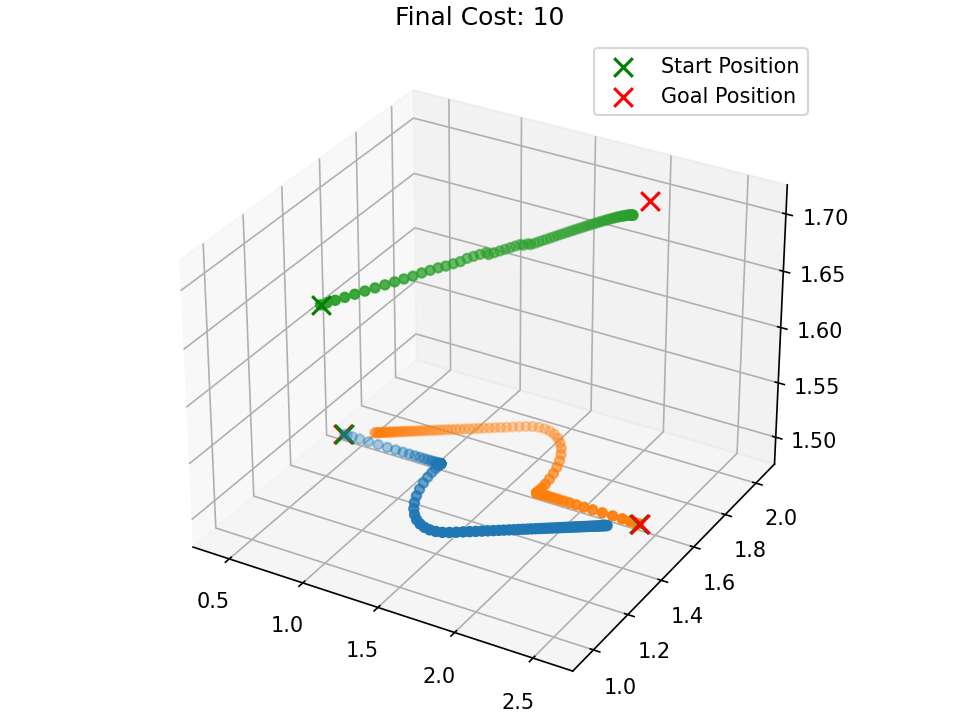

In [35]:
%matplotlib ipympl
plt.figure(dpi=150)
plot_solve(X_full,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
# plt.title('Centralized RHC (IPOPT) (1 human & 2 drones)')
plt.savefig('one_human_2_drones(centralized RHC).png')

In [32]:
X_trj = X_full

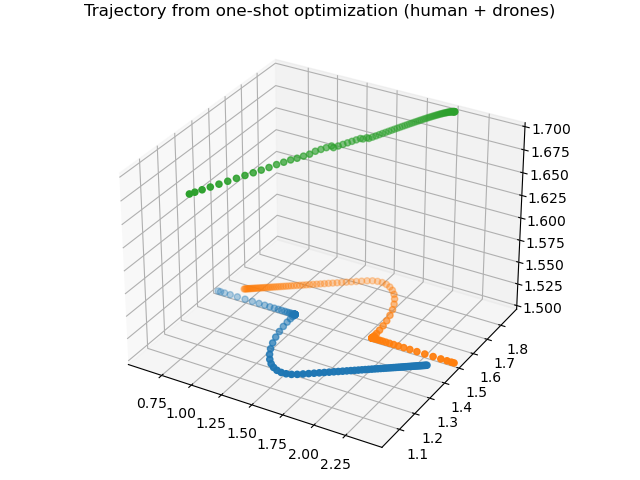

In [33]:
#animate the plot:

import matplotlib.animation as animation


# first, fill X_trj with some test data


# second, create a function that updates the scatter plot for each frame
def update_plot(k, X_trj, scatters):
     # Set the data for each scatter plot
    scatters[0]._offsets3d = X_trj.T[0:3, :k]
    scatters[1]._offsets3d = X_trj.T[6:9, :k]
    scatters[2]._offsets3d = X_trj.T[12:15, :k]
    return scatters

# Create the figure and axis
fig = plt.figure()
ax = plt.axes(projection='3d')

# Create the scatter plots
scatters = []
scatters.append(ax.scatter([], [], []))
scatters.append(ax.scatter([], [], []))
scatters.append(ax.scatter([], [], []))

# set the axis limits
ax.set_xlim3d(X_trj.T[[0, 6, 12], :].min(), X_trj.T[[0, 6, 12], :].max())
ax.set_ylim3d(X_trj.T[[1, 7, 13], :].min(), X_trj.T[[1, 7, 13], :].max())
ax.set_zlim3d(X_trj.T[[2, 8, 14], :].min(), X_trj.T[[2, 8, 14], :].max())


# Set the title
ax.set_title('Trajectory from one-shot optimization (human + drones)')

ani = animation.FuncAnimation(fig, update_plot, frames=100, fargs=(X_trj, scatters))

ani.save('1_human_2_drones(centralized).mp4')
plt.show()

## Running inhomogenous test with 3 quadrotors and 2 human (centralized receding-horizon):

In [ ]:
#3 drones + 2 human:
n_agents = 5
n_states = 6
n_humans = 2
n_dims = [3,3,3,2,2]
x_dims = [6,6,6,6,6]
u_dims = [3,3,3,3,3]

x0 = np.array([[0.5, 1.5, 1. , 0. , 0. , 0. ,   #Drone
               2.5, 1.5, 1. , 0. , 0. , 0.,   #Drone
              1.5, 1.3, 1. , 0. , 0. , 0.,  #Drone
              1, 1, 1.7, 0.01, 0, 0 , #Human 1
              2.1, 2.1, 1.7, -0.01, 0, 0]]).T # Human 2

xf = np.array([[ 2.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                0.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                1.5, 2.2, 1. , 0. , 0. , 0. , #Drone
                2., 2., 1.7, 0,  0,  0,  
                1., 1., 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,0,0,0,0])


opti = Opti()

dt = 0.1

In [ ]:
x_dims

In [ ]:
f = generate_f_human_drone(x_dims,n_humans)

In [ ]:
max_input = np.tile(max_input_base,(n_agents-n_humans,1))
min_input = np.tile(min_input_base,(n_agents-n_humans,1))
max_state = np.tile(max_state_base,(n_agents-n_humans,1))
min_state = np.tile(min_state_base,(n_agents-n_humans,1))

In [ ]:
u_dims

In [ ]:
radius = 0.5
N = 10
t0 = perf_counter()
X_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,radius,n_dims,u_dims)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

In [ ]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_trj,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Centralized RHC (IPOPT) (2 humans & 3 drones)')
plt.savefig('results/two_human_3_drones(Centralized RHC).png')

In [ ]:
#5 drones + 3 humans
n_agents = 8
n_states = 6
n_humans = 3
n_dims = [3,3,3,3,3,2,2,2]
x_dims = [6,6,6,6,6,6,6,6]
u_dims = [3,3,3,3,3,3,3,3]

x0 = np.array([[0.5, 1.5, 1. , 0. , 0. , 0. ,   #Drone 1
               2.5, 1.5, 1. , 0. , 0. , 0.,   #Drone 2
               1.5, 1.3, 1. , 0. , 0. , 0.,  #Drone 3
              -1.5, 1.0, 1, 0., 0., 0.,  #Drone 4
              -2.5, -1.5, 1, 0., 0., 0., #Drone 5
               1., 1.1, 1.7, 0.01, 0., 0., #Human 1
               2.1, 2.1, 1.7, -0.01, 0, 0,#Human 2
               -0.5, -0.5, 1.7, 0.01, 0, 0]]).T #Human 3

xf = np.array([[ 2.5, 1.5, 1. , 0. , 0. , 0. , #Drone 1
                0.5, 1.5, 1. , 0. , 0. , 0. , #Drone 2
                -1.5, -2.2, 1. , 0. , 0. , 0. , #Drone 3
                1.2, 1.0, 1., 0., 0., 0., #Drone 4
                0.2, 0.2, 1., 0., 0., 0., #Drone 5
                -2., -2., 1.7, 0,  0,  0,  #Human 1
                -2.8, -1.6, 1.7, 0,  0,  0,  #Human 2
                2.3, 2.1, 1.7, 0., 0., 0.   ]]).T #Human 3

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,g,0,0,g,
                  0,0,0,0,0,0,0,0,0])


opti = Opti()

dt = 0.1


In [ ]:
f = generate_f_human_drone(x_dims,n_humans)

In [ ]:
max_input = np.tile(max_input_base,(n_agents-n_humans,1))
min_input = np.tile(min_input_base,(n_agents-n_humans,1))
max_state = np.tile(max_state_base,(n_agents-n_humans,1))
min_state = np.tile(min_state_base,(n_agents-n_humans,1))

In [ ]:
radius = 0.7
N = 10
t0 = perf_counter()
X_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,radius,n_dims,u_dims)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

In [ ]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_trj,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Centralized RHC (3 humans & 5 drones)')
plt.savefig('results/three_humans_5_drones(Centralized RHC).png')

## Re-run the above simulations in distributed fashion:

In [6]:
from distributed_mpc import solve_rhc_distributed

In [7]:
#2 drones + 1 human:
n_agents = 3
n_humans = 1
n_states = 6
n_inputs = 3
n_dims = [3,3,2]
x_dims = [6,6,6]
u_dims = [3,3,3]

x0 = np.array([[0.5, 1.5, 1.5, 0, 0, 0,   #Drone
               2.5, 1.5, 1.5, 0, 0, 0,   #Drone
               1, 1, 1.7, 0.01, 0, 0]]).T #Human 

xf = np.array([[ 2.5, 1.5, 1.5, 0, 0, 0, 
                0.5, 1.5, 1.5, 0, 0, 0,
                2, 2, 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,0])

dt = 0.1

theta_max = np.pi / 6
phi_max = np.pi / 6

v_max = 3
v_min = -3

theta_min = -np.pi / 6
phi_min = -np.pi / 6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.5

radius = 0.5
N = 10
ids = [100 + i for i in range(n_agents)]

In [11]:
X_full, U_full, t, J_list, failed_count, converged = solve_rhc_distributed(
    x0, xf, u_ref, N, n_agents, n_states, n_inputs, radius, ids,\
    x_min,x_max,y_min,y_max,z_min,z_max,v_min,v_max,theta_max,\
  theta_min,tau_max,tau_min,phi_max,phi_min,n_humans,n_dims)

determining interaction graph with the following pair-wise distance : [[2.    0.908 1.781]]
Solving the 0th sub-problem at iteration 0, t = 0 

current sub-problem has state dimension : [6, 6] 

n_dims is [3, 2]
number of drones in the current subproblem is 1

number of humans in the current subproblem is 1

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 109.20us (  4.37us)        25
       nlp_g  |        0 (       0) 246.80us (  9.87us)        25
  nlp_grad_f  |        0 (       0) 141.30us (  5.43us)        26
  nlp_hess_l  |        0 (       0) 308.30us ( 12.85us)        24
   nlp_jac_g  |        0 (       0) 374.10us ( 14.39us)        26
       total  |  62.50ms ( 62.50ms)  56.64ms ( 56.64ms)         1
solve time for the current sub-problem is 0.07068780000554398 

objective value for the 0th subproblem at iteration 0 is 6958.205800075666 

Solving the 1th sub-problem at iteration 0, t = 0 

current sub-problem has state dimen

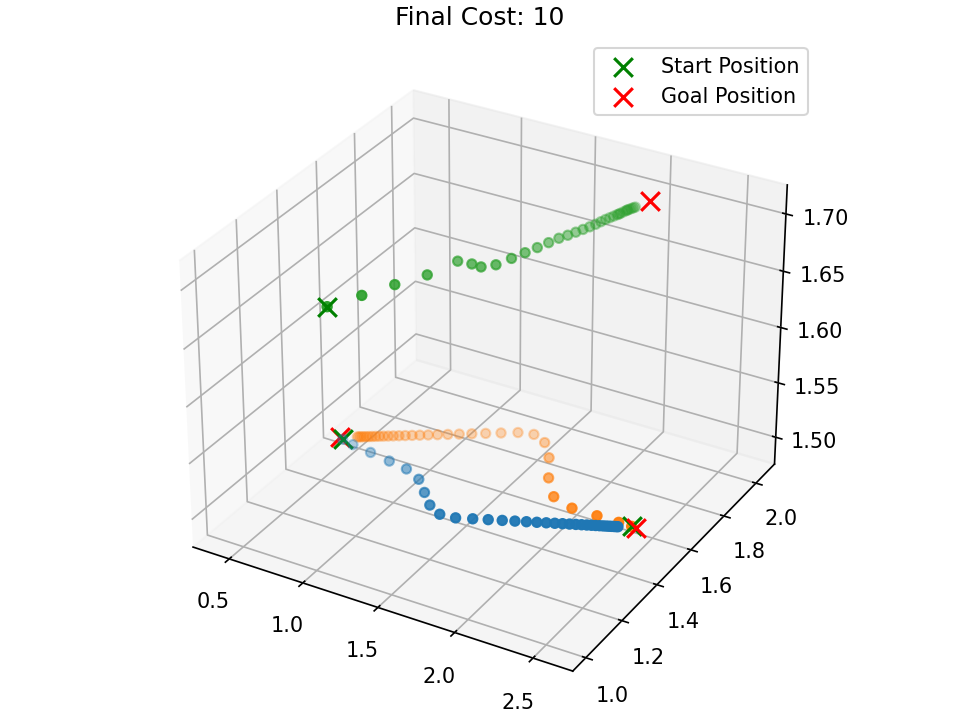

In [13]:
%matplotlib ipympl
plt.figure(dpi=150)
plot_solve(X_full,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
# plt.title('Distributed RHC (IPOPT) (1 humans & 2 drones)')
plt.savefig('one_human_2_drones(distributed).png')

In [ ]:
#3 drones + 2 human:
n_agents = 5
ids = [100 + i for i in range(n_agents)]
n_states = 6
n_humans = int(2)
n_inputs=3
n_dims = [3,3,3,2,2]
x_dims = [6,6,6,6,6]
u_dims = [3,3,3,3,3]

x0 = np.array([[0.5, 1.5, 1. , 0. , 0. , 0. ,   #Drone
               2.5, 1.5, 1. , 0. , 0. , 0.,   #Drone
              1.5, 1.3, 1. , 0. , 0. , 0.,  #Drone
              1, 1, 1.7, 0.01, 0, 0 , #Human 1
              2.1, 2.1, 1.7, -0.01, 0, 0]]).T # Human 2

xf = np.array([[ 2.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                0.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                1.5, 2.2, 1. , 0. , 0. , 0. , #Drone
                2., 2., 1.7, 0,  0,  0,  
                1., 1., 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,0,0,0,0])

radius = 0.35

N = 15

In [ ]:
ids = [100 + i for i in range(n_agents)]
X_full, U_full, t, J_list, failed_count, converged = solve_rhc_distributed(
    x0, xf, u_ref, N, n_agents, n_states, n_inputs, radius, ids,\
    x_min,x_max,y_min,y_max,z_min,z_max,v_min,v_max,theta_max,\
  theta_min,tau_max,tau_min,phi_max,phi_min,n_humans,n_dims)

In [ ]:
ids[-n_humans:]

In [ ]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_full,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Distributed RHC (IPOPT) (2 humans & 3 drones)')
plt.savefig('results/two_human_3_drones_distributed.png')

In [ ]:
#5 drones + 3 human:
n_agents = 8
n_states = 6
n_humans = 3
n_dims = [3,3,3,3,3,2,2,2]
x_dims = [6,6,6,6,6,6,6,6]
u_dims = [3,3,3,3,3,3,3,3]

x0 = np.array([[0.5, 1.5, 1. , 0. , 0. , 0. ,   #Drone 1
               2.5, 1.5, 1. , 0. , 0. , 0.,   #Drone 2
               1.5, 1.3, 1. , 0. , 0. , 0.,  #Drone 3
              -1.5, 1.0, 1, 0., 0., 0.,  #Drone 4
              -2.5, -1.5, 1, 0., 0., 0., #Drone 5
               1., 1.1, 1.7, 0.01, 0., 0., #Human 1
               2.1, 2.1, 1.7, -0.01, 0, 0,#Human 2
               -0.5, -0.5, 1.7, 0.01, 0, 0]]).T #Human 3

xf = np.array([[ 2.5, 1.5, 1. , 0. , 0. , 0. , #Drone 1
                0.5, 1.5, 1. , 0. , 0. , 0. , #Drone 2
                -1.5, -2.2, 1. , 0. , 0. , 0. , #Drone 3
                1.2, 1.0, 1., 0., 0., 0., #Drone 4
                0.2, 0.2, 1., 0., 0., 0., #Drone 5
                -2., -2., 1.7, 0,  0,  0,  #Human 1
                -2.8, -1.6, 1.7, 0,  0,  0,  #Human 2
                2.3, 2.1, 1.7, 0., 0., 0.   ]]).T #Human 3

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,g,0,0,g,
                  0,0,0,0,0,0,0,0,0])


radius = 0.15

N = 15

In [ ]:
n_agents

In [ ]:
ids = [100 + i for i in range(n_agents)]
X_full, U_full, t, J_list, failed_count, converged = solve_rhc_distributed(
    x0, xf, u_ref, N, n_agents, n_states, n_inputs, radius, ids,\
    x_min,x_max,y_min,y_max,z_min,z_max,v_min,v_max,theta_max,\
  theta_min,tau_max,tau_min,phi_max,phi_min,n_humans,n_dims)

In [ ]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_full,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Distributed RHC (IPOPT) (3 humans & 4 drones)')
plt.savefig('results/three_human_4_drones_distributed.png')